# COURSE: A deep understanding of deep learning
## SECTION: Regularization
### LECTURE: Batch training in action
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202401

In [66]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

In [67]:
# import dataset
import pandas as pd
iris = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv')

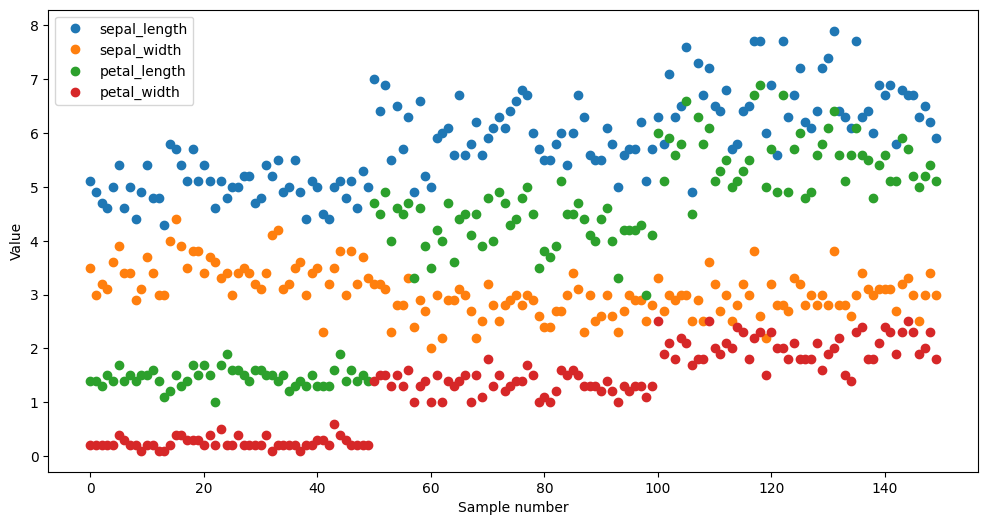

In [68]:
# plot the data
iris.plot(marker='o',linestyle='none',figsize=(12,6))
plt.xlabel('Sample number')
plt.ylabel('Value')
plt.show()

In [69]:
####   ------------------------------- < NOTE ABOUT THIS CELL!!! > ---------------------------------------   ####
#                                                                                                               #
# The code here is intentionally commented out. We're going to use this in the lecture "The importance of       #
# data standardization" in the next section. If you're not doing that lecture, leave this commented! Thanks!    #
#                                                                                                               #
####   ------------------------------- </ NOTE ABOUT THIS CELL!!! > --------------------------------------   ####


# # z-score the data
# import scipy.stats as stats
# cols2zscore = iris.keys()
# cols2zscore = cols2zscore.drop('species')
# iris[cols2zscore] = iris[cols2zscore].apply(stats.zscore)

# iris.plot(marker='o',linestyle='none',figsize=(12,6))
# plt.xlabel('Sample number')
# plt.ylabel('Value')
# plt.show()

In [70]:
# organize the data

# convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa']   = 0 # don't need!
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica']  = 2

# Put the data in Tensors (we will break it later)

In [71]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.2)


# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)


# Construct the model and training plans

In [72]:
# a function that creates the ANN model

def createANewModel():

  # model architecture
  ANNiris = nn.Sequential(
      nn.Linear(4,64),   # input layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,64),  # hidden layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,3),   # output units
        )

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(ANNiris.parameters(),lr=0.001) # we slow learning down to see more variability and study better

  return ANNiris,lossfun,optimizer

In [73]:
# train the model

# global parameter
numepochs = 2500

def trainTheModel():

  # initialize accuracies as empties
  trainAcc = []
  testAcc  = []
  losses   = []

  # loop over epochs
  for epochi in range(numepochs):

    ANNiris.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = ANNiris(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # compute training accuracy just for this batch
      batchAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
      batchLoss.append( loss.item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )
    losses.append( np.mean(batchLoss) )

    ANNiris.eval()

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): #deactivates gradient calculation, so less overhead
      predlabels = torch.argmax( ANNiris(X),axis=1 )
    testAcc.append( 100*torch.mean((predlabels == y).float()).item() )

  # function output
  return trainAcc,testAcc,losses


# Test it out

In [74]:
# create a model
ANNiris,lossfun,optimizer = createANewModel()

# create the temporal dataloaders to test (later will be rewritten)
test_batchsize = 16
train_loader = DataLoader(train_data,batch_size=test_batchsize,shuffle=True)
test_loader  = DataLoader(test_data,batch_size=len(test_data),shuffle=False)

# train the model
trainAcc,testAcc,losses = trainTheModel()


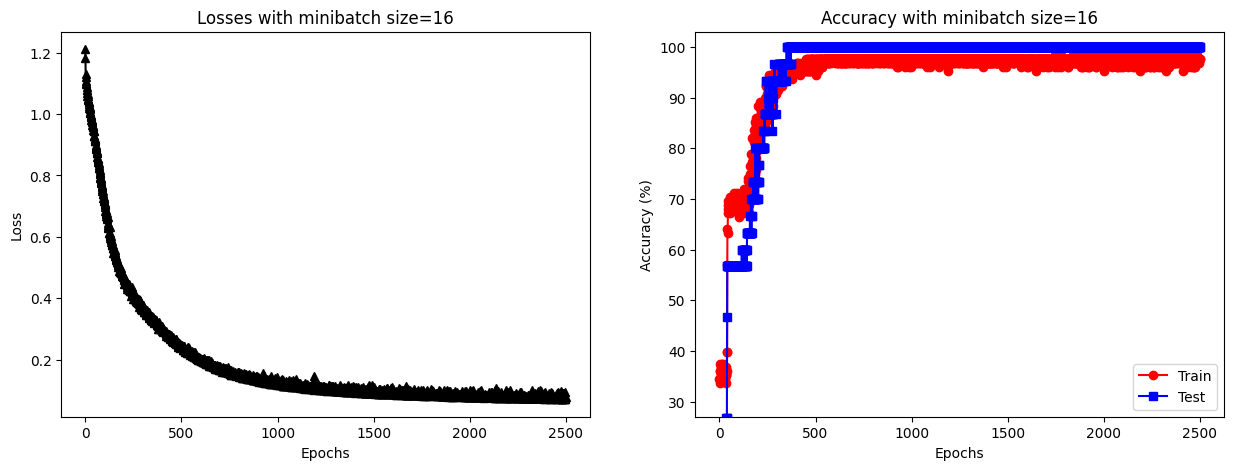

In [75]:
# plot the results
fig,ax = plt.subplots(1,2,figsize=(15,5))


ax[0].plot(losses,'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses with minibatch size=' + str(test_batchsize))

ax[1].plot(trainAcc,'ro-')
ax[1].plot(testAcc,'bs-')
ax[1].set_title('Accuracy with minibatch size=' + str(test_batchsize))
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train','Test'])
ax[1].set_ylim([27,103])

plt.show()

# Let's do the experiment

In [76]:

# we set up the experiment sizes
batchsize_powers_list = np.arange(1,7,1)
trainAccResults = np.zeros((numepochs, len(batchsize_powers_list)))
testAccResults  = np.zeros((numepochs, len(batchsize_powers_list)))
lossesResults   = np.zeros((numepochs, len(batchsize_powers_list)))
    
# Smooth the results with a range of 5 values
def smooth(data, range_val=5):
    smoothed_data = np.convolve(data, np.ones(range_val)/range_val, mode='same')
    return smoothed_data

# We do a loop over the batch sizes
for idx, power in enumerate(batchsize_powers_list):
    batchsize = 2**power

    train_loader = DataLoader(train_data,batch_size=int(batchsize),shuffle=True,drop_last=True)
    test_loader  = DataLoader(test_data,batch_size=len(test_data))

    ANNiris,lossfun,optimizer = createANewModel()
    trainAcc,testAcc,losses = trainTheModel()

    trainAccResults[:, idx] = smooth(trainAcc)
    testAccResults[:, idx] = smooth(testAcc)
    lossesResults[:, idx] = smooth(losses)


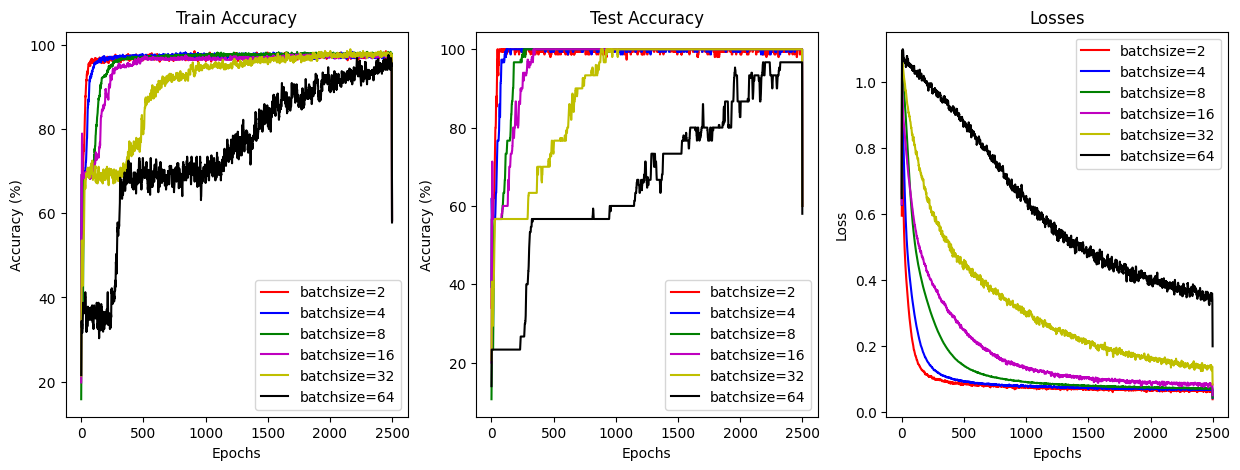

In [77]:
# plot the results
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].plot(trainAccResults[:, 0], 'r-', label='batchsize=2')
ax[0].plot(trainAccResults[:, 1], 'b-', label='batchsize=4')
ax[0].plot(trainAccResults[:, 2], 'g-', label='batchsize=8')
ax[0].plot(trainAccResults[:, 3], 'm-', label='batchsize=16')
ax[0].plot(trainAccResults[:, 4], 'y-', label='batchsize=32')
ax[0].plot(trainAccResults[:, 5], 'k-', label='batchsize=64')
ax[0].set_ylabel('Accuracy (%)')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Train Accuracy')
ax[0].legend()

ax[1].plot(testAccResults[:, 0], 'r-', label='batchsize=2')
ax[1].plot(testAccResults[:, 1], 'b-', label='batchsize=4')
ax[1].plot(testAccResults[:, 2], 'g-', label='batchsize=8')
ax[1].plot(testAccResults[:, 3], 'm-', label='batchsize=16')
ax[1].plot(testAccResults[:, 4], 'y-', label='batchsize=32')
ax[1].plot(testAccResults[:, 5], 'k-', label='batchsize=64')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_xlabel('Epochs')
ax[1].set_title('Test Accuracy')
ax[1].legend()

ax[2].plot(lossesResults[:, 0], 'r-', label='batchsize=2')
ax[2].plot(lossesResults[:, 1], 'b-', label='batchsize=4')
ax[2].plot(lossesResults[:, 2], 'g-', label='batchsize=8')
ax[2].plot(lossesResults[:, 3], 'm-', label='batchsize=16')
ax[2].plot(lossesResults[:, 4], 'y-', label='batchsize=32')
ax[2].plot(lossesResults[:, 5], 'k-', label='batchsize=64')
ax[2].set_ylabel('Loss')
ax[2].set_xlabel('Epochs')
ax[2].set_title('Losses')
ax[2].legend()

plt.show()